In [50]:
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds


In [51]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [52]:
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.reshape(-1, 28, 28)
            plt.figure(figsize=(18, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = out.reshape(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

In [53]:
tf.random.set_seed(1)

In [54]:
batch_size = 256
ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
train_dataset = ds[0]
test_dataset = ds[1]

In [55]:
for item in train_dataset:
    print(np.min(item[0].numpy()))
    print(np.max(item[0].numpy()))
    break

0
255


In [56]:
# Because dataset is from 0->255, we convert the values to be in range 0->1

def processing_images(data, label):
    # Normalize to be -1 to 1
    data = tf.cast(data, tf.float32) / 255
    #data = tf.where(data > 0.5, 1.0, 0.0)
    return data, label

train_dataset = train_dataset.map(processing_images)
test_dataset = test_dataset.map(processing_images)

In [57]:
for item in train_dataset:
    print(np.min(item[0].numpy()))
    print(np.max(item[0].numpy()))
    break

0.0
1.0


In [58]:
train_dataset = train_dataset.shuffle(buffer_size=100000).batch(batch_size)
test_dataset = test_dataset.shuffle(buffer_size=100000).batch(batch_size)

In [59]:
class VAE(tf.keras.Model):
    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.encoder = tf.keras.Sequential([
            tf.keras.Input(shape = (784,)),
            tf.keras.layers.Dense(units = hidden_dim ** 2),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(units = hidden_dim * 2)
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.Input(shape = (hidden_dim,)),
            tf.keras.layers.Dense(units =  hidden_dim **2),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Dense(units = 784),
            tf.keras.layers.Activation('sigmoid')
        ])
        
    def reparameterise(self, mean, logstd, training=None):
        if training:
            std = tf.exp(0.5 * logstd)
            z = mean + tf.math.multiply(tf.random.normal(std.shape), std)
            return z
        else:
            return mean
        
    def call(self, x, training=None):
        mu_logstd = self.encoder(x)
        mu_logstd = tf.reshape(mu_logstd, (-1, 2, self.hidden_dim))
        mu = mu_logstd[:, 0, :]
        logstd = mu_logstd[:, 1, :]
        z = self.reparameterise(mu, logstd, training)
        x_hat = self.decoder(z)
        return x_hat, mu, logstd

In [60]:
def loss_object(prediction, target, mu, logstd):
    #bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true = target, 
    #            y_pred = prediction, from_logits = False))
    
    bce = tf.reduce_mean(tf.reduce_sum(tf.math.multiply(-target, tf.math.log(prediction)) - \
                                       tf.math.multiply(1-target,tf.math.log(1-prediction)), axis=-1))
    kld = tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(logstd) - logstd - 1 + mu**2, axis=-1))
    return bce + kld


In [61]:
d = 20
model = VAE(d)
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

====> Test set loss: 545.6465
====> Epoch: 1 Average loss: 189.1191
====> Test set loss: 133.0930
====> Epoch: 2 Average loss: 132.4003
====> Test set loss: 116.3212
====> Epoch: 3 Average loss: 122.0155
====> Test set loss: 109.2878
====> Epoch: 4 Average loss: 117.1360
====> Test set loss: 105.4112
====> Epoch: 5 Average loss: 114.3473
====> Test set loss: 103.8089
====> Epoch: 6 Average loss: 112.3793
====> Test set loss: 102.5792
====> Epoch: 7 Average loss: 111.0241
====> Test set loss: 100.9686
====> Epoch: 8 Average loss: 109.8919
====> Test set loss: 100.1515
====> Epoch: 9 Average loss: 109.1024
====> Test set loss: 99.8725
====> Epoch: 10 Average loss: 108.4587
====> Test set loss: 98.9516


<ipython-input-52-8977a9009b78>:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(18, 4))


====> Epoch: 11 Average loss: 107.8439
====> Test set loss: 98.6404
====> Epoch: 12 Average loss: 107.3285
====> Test set loss: 97.8582
====> Epoch: 13 Average loss: 106.9067
====> Test set loss: 97.3217
====> Epoch: 14 Average loss: 106.5527
====> Test set loss: 96.4516
====> Epoch: 15 Average loss: 106.2248
====> Test set loss: 96.2686
====> Epoch: 16 Average loss: 105.9249
====> Test set loss: 96.4553
====> Epoch: 17 Average loss: 105.6278
====> Test set loss: 95.8336
====> Epoch: 18 Average loss: 105.4433
====> Test set loss: 96.6805
====> Epoch: 19 Average loss: 105.2040
====> Test set loss: 95.8343


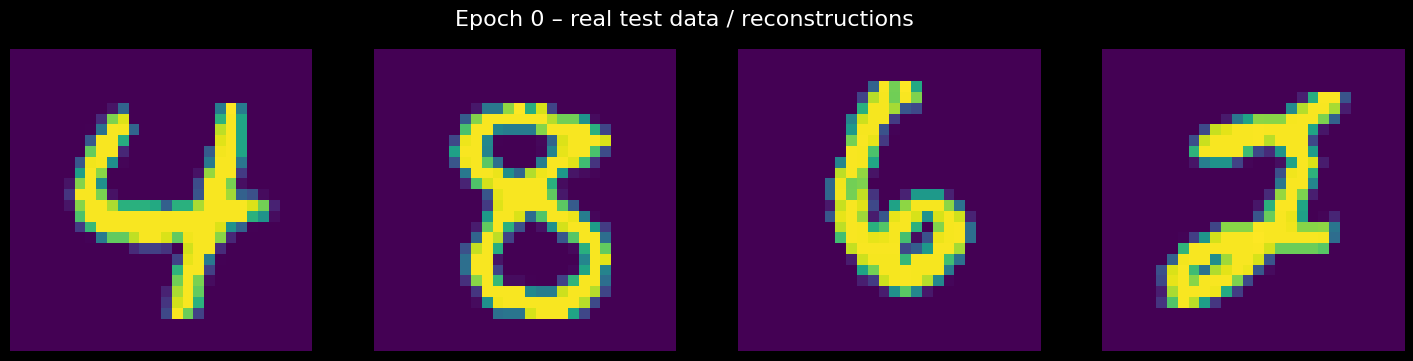

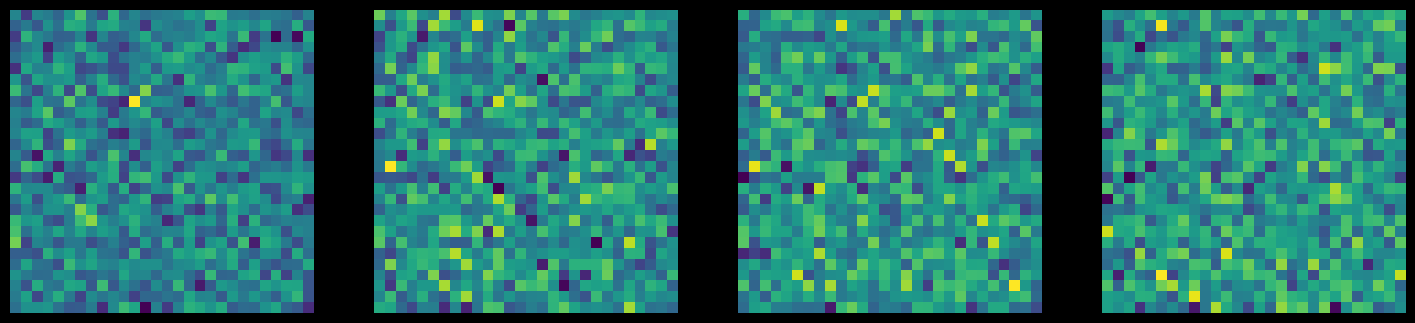

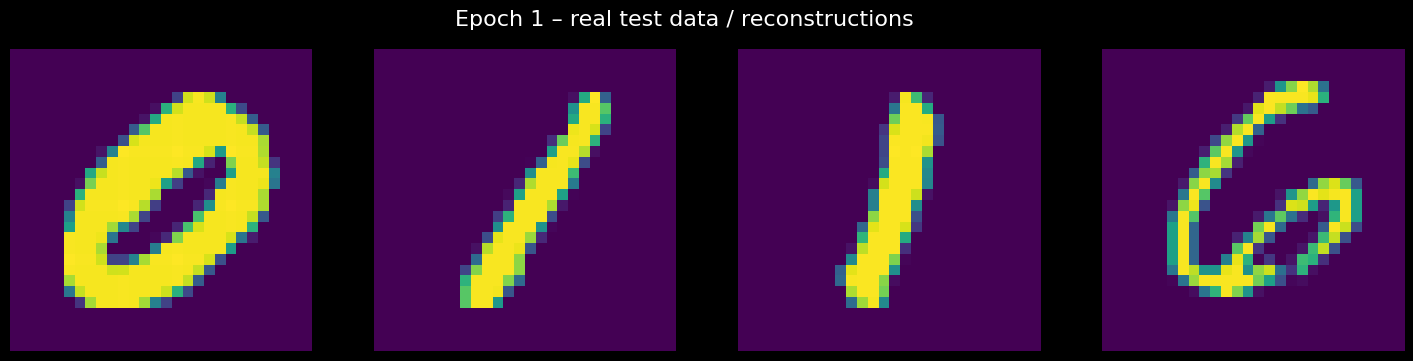

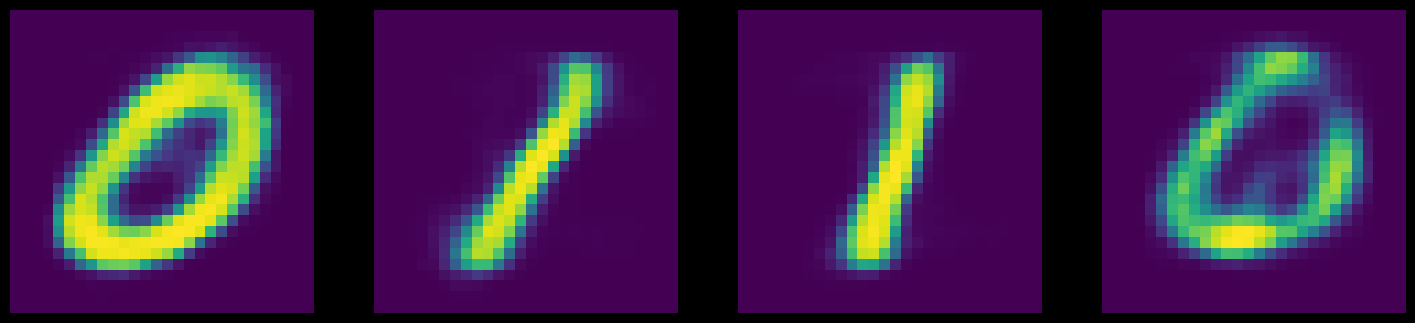

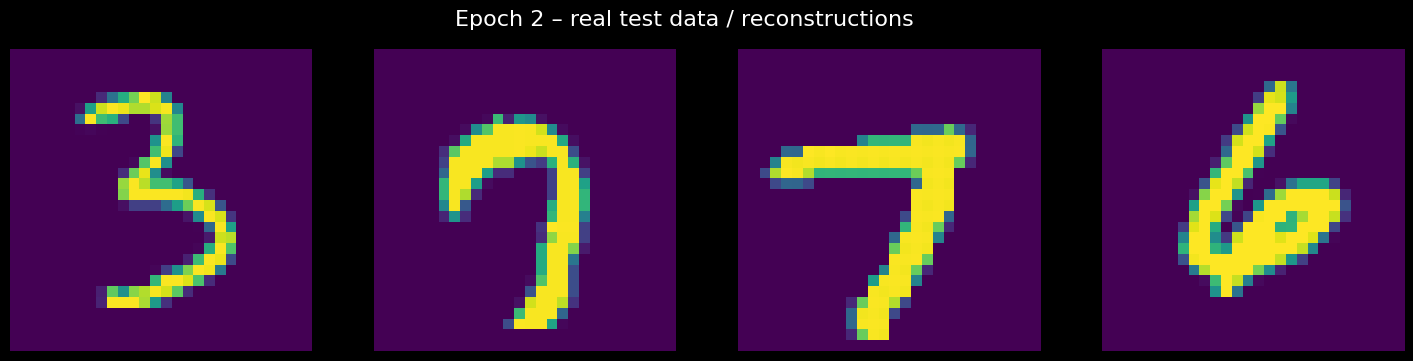

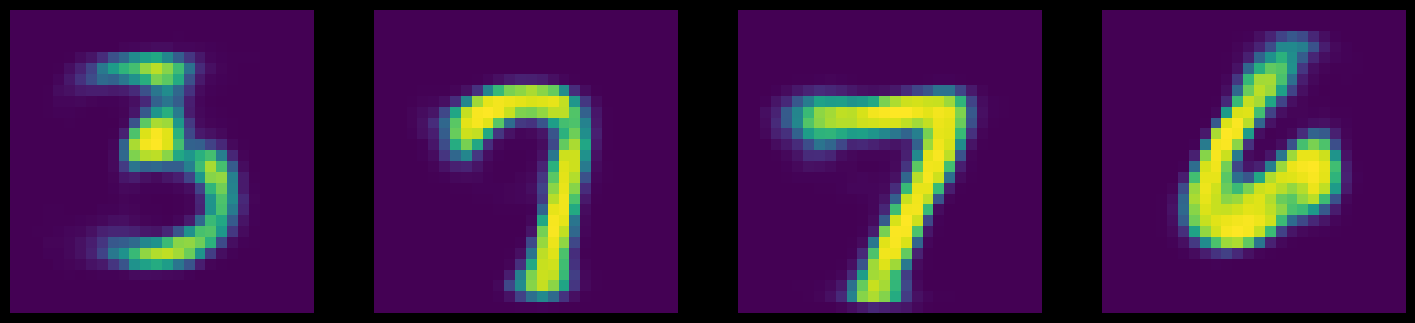

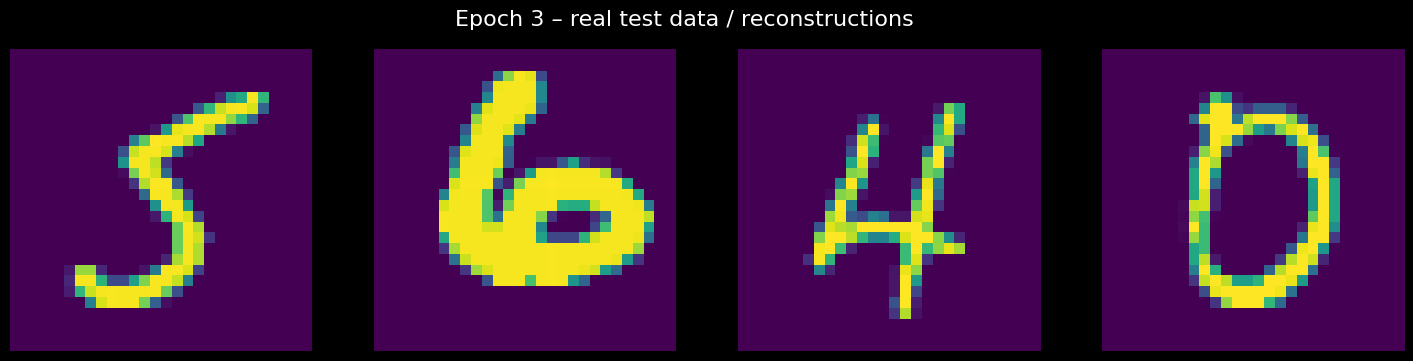

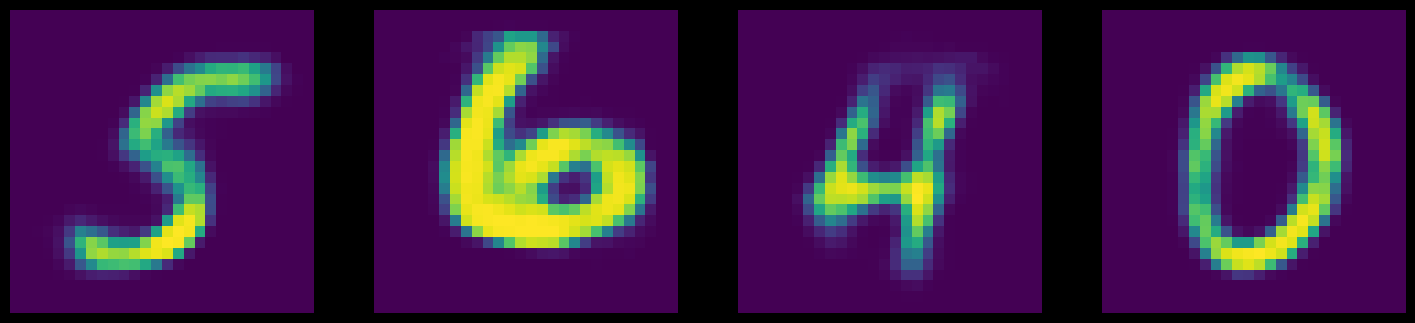

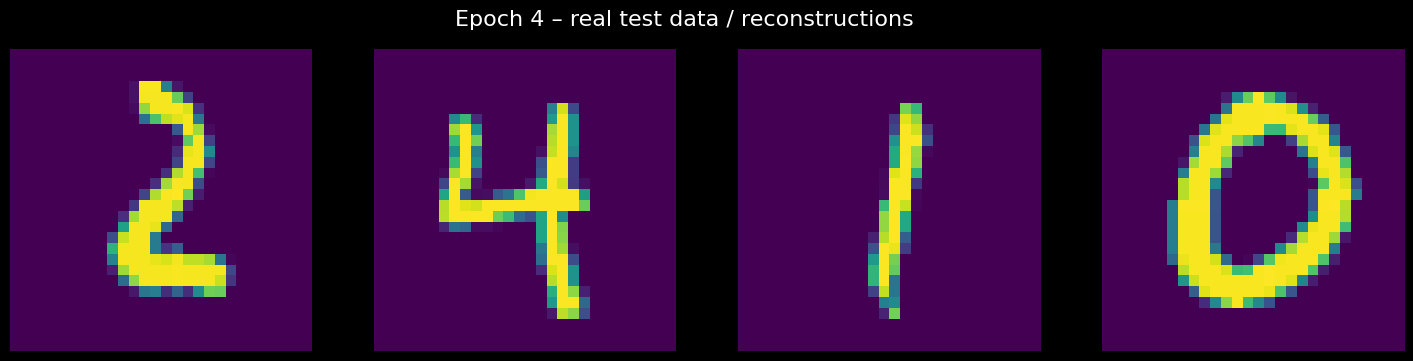

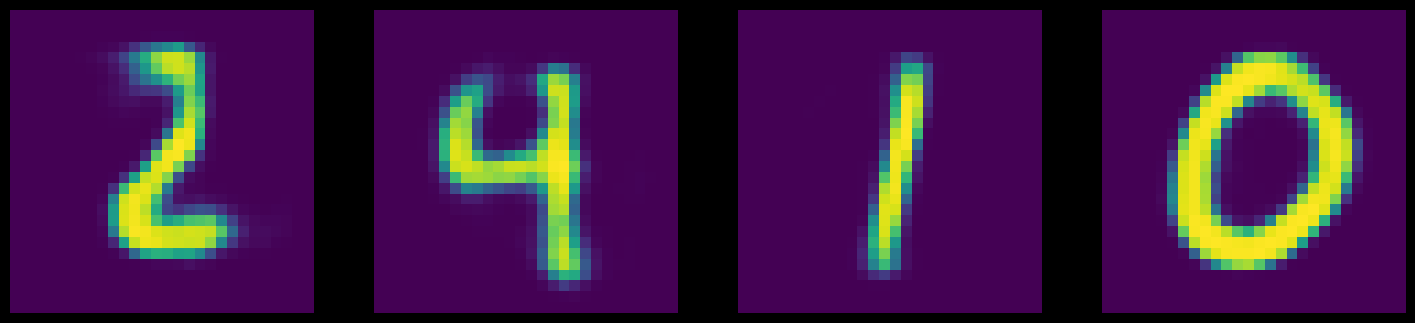

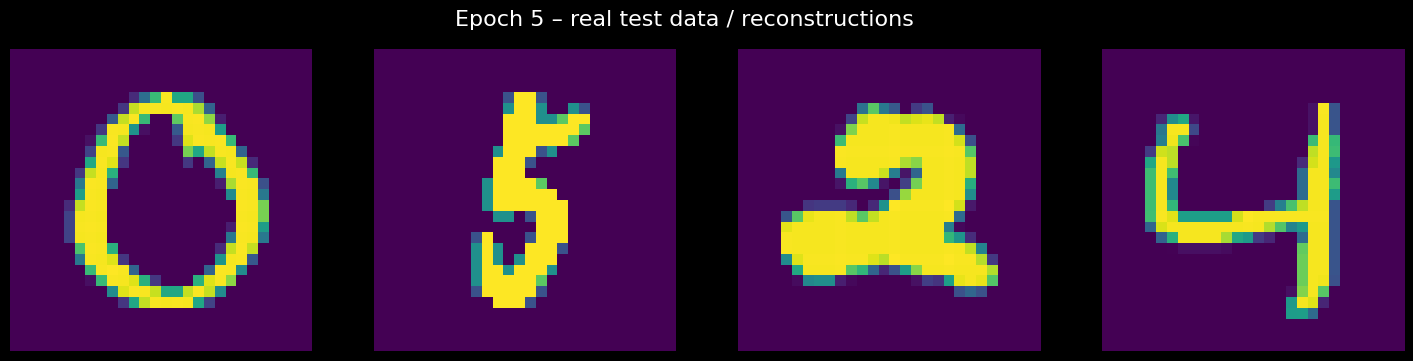

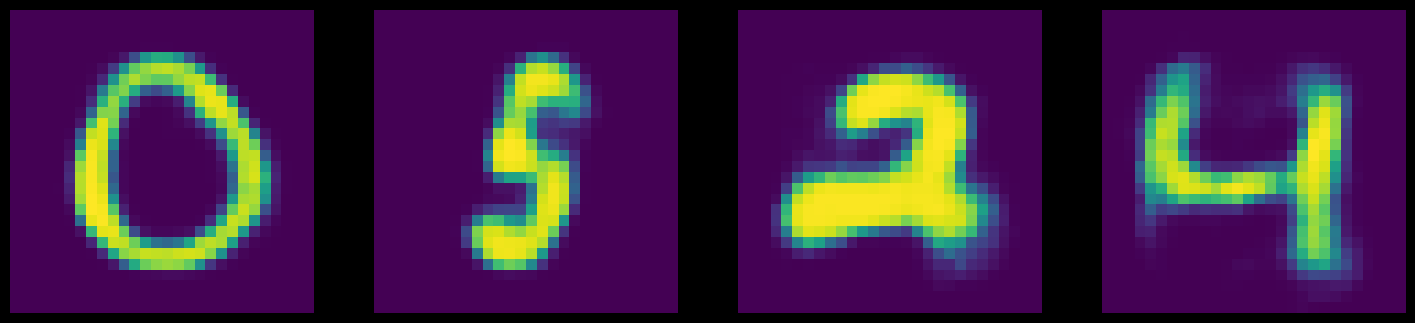

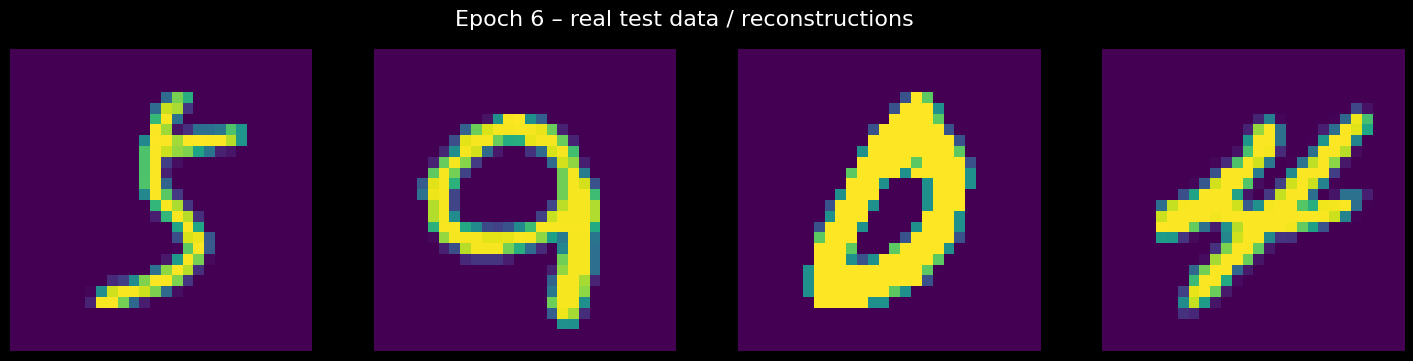

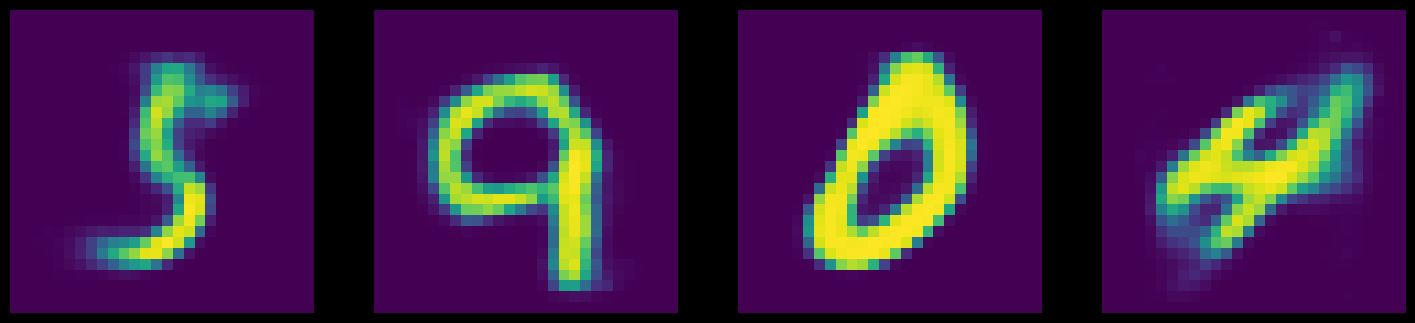

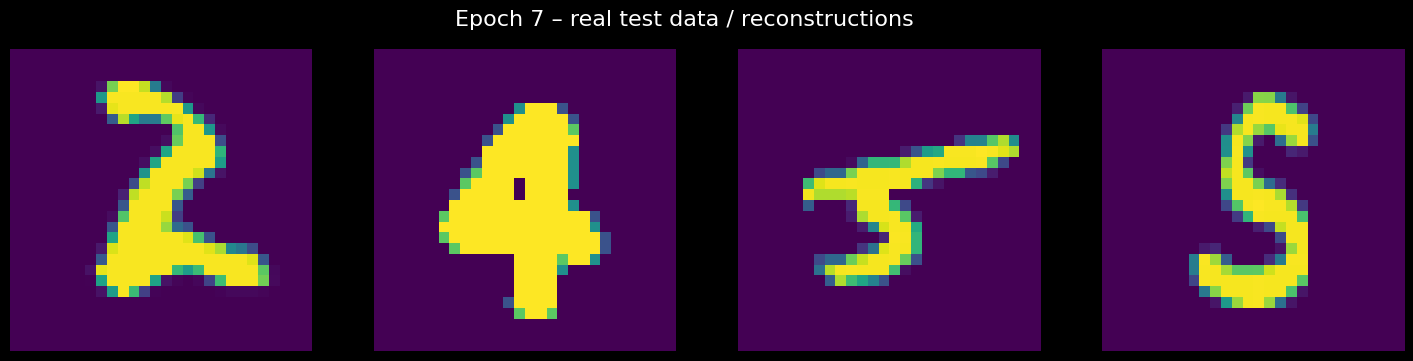

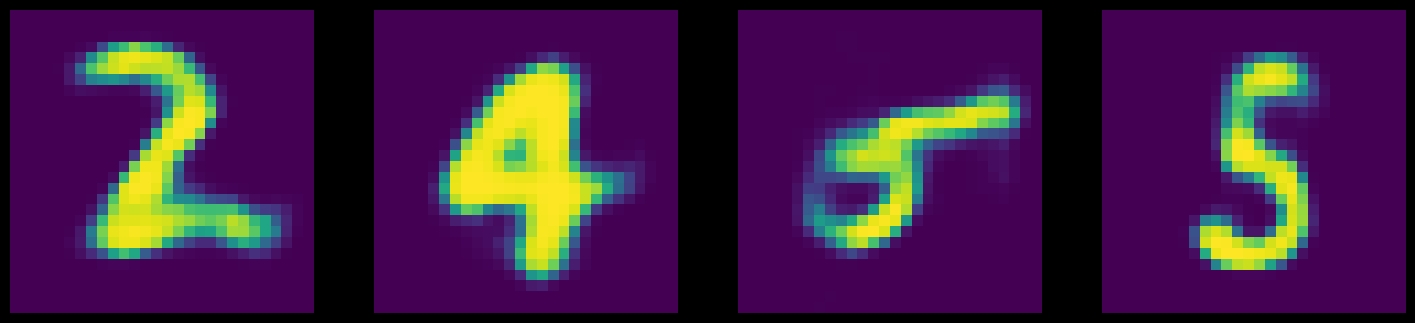

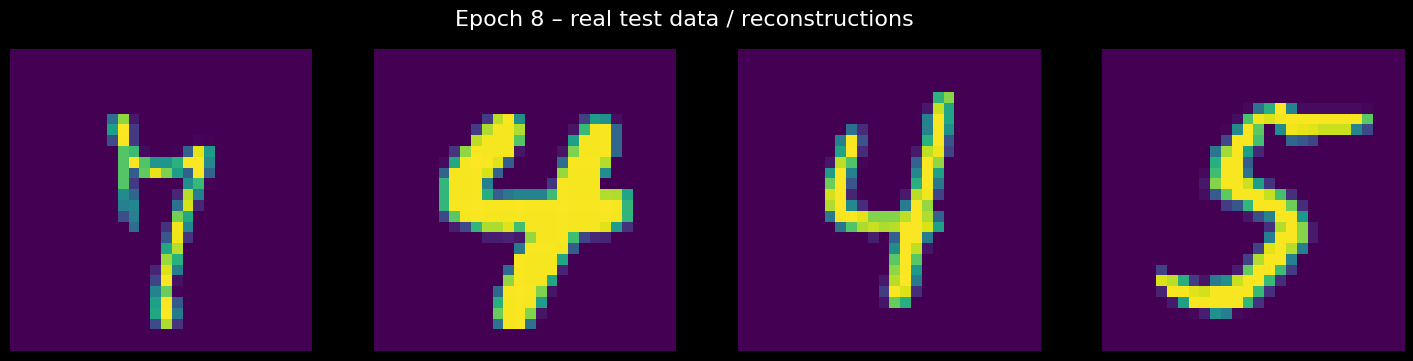

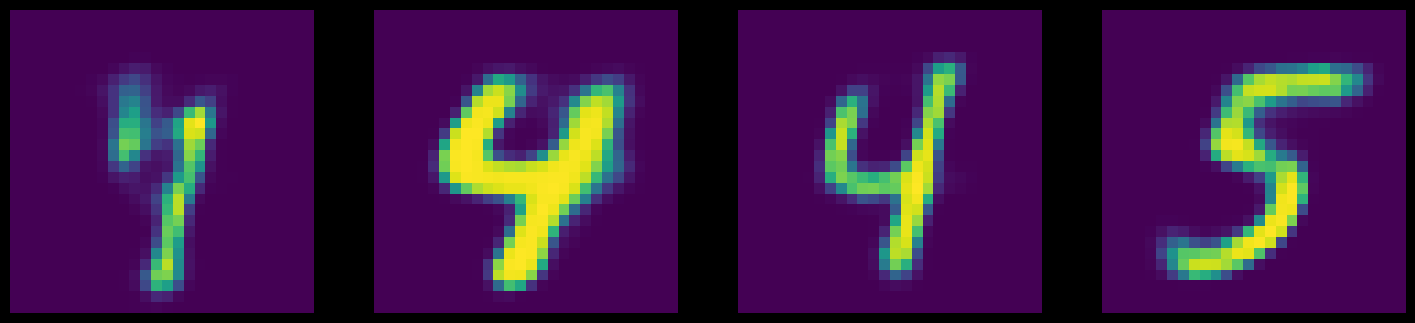

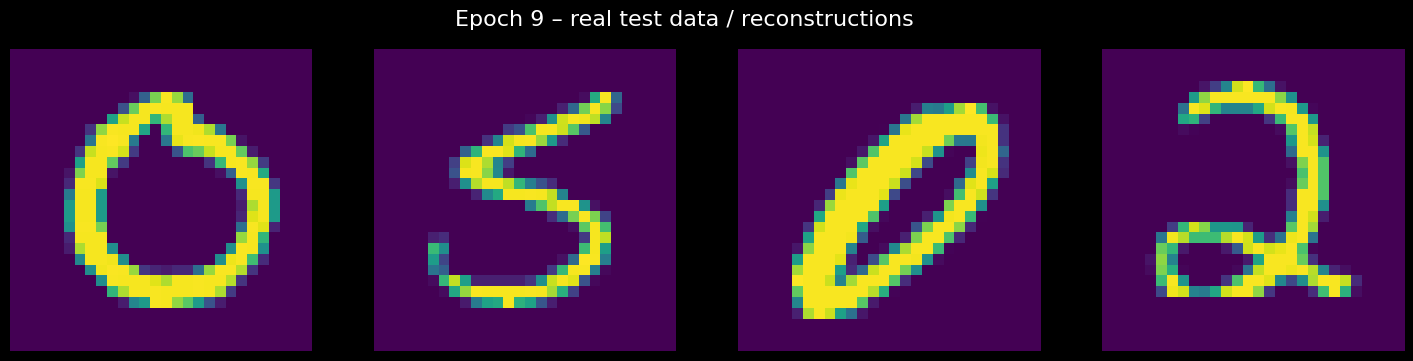

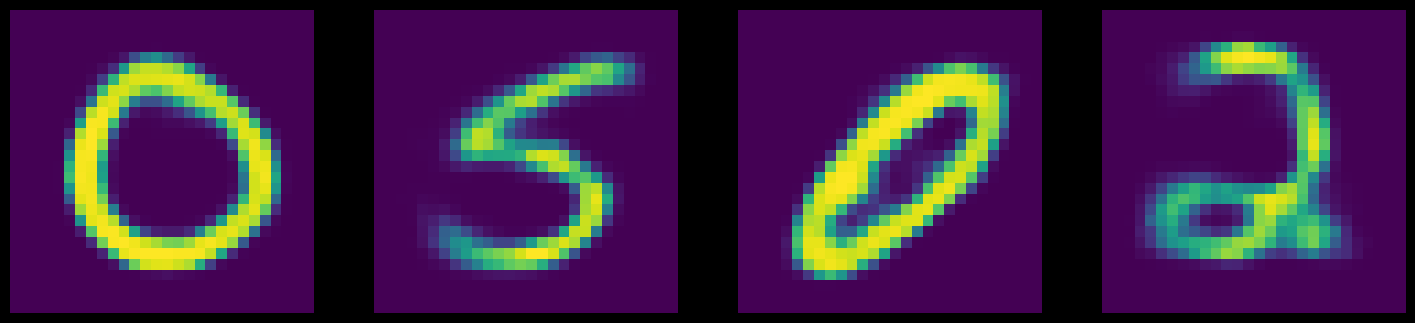

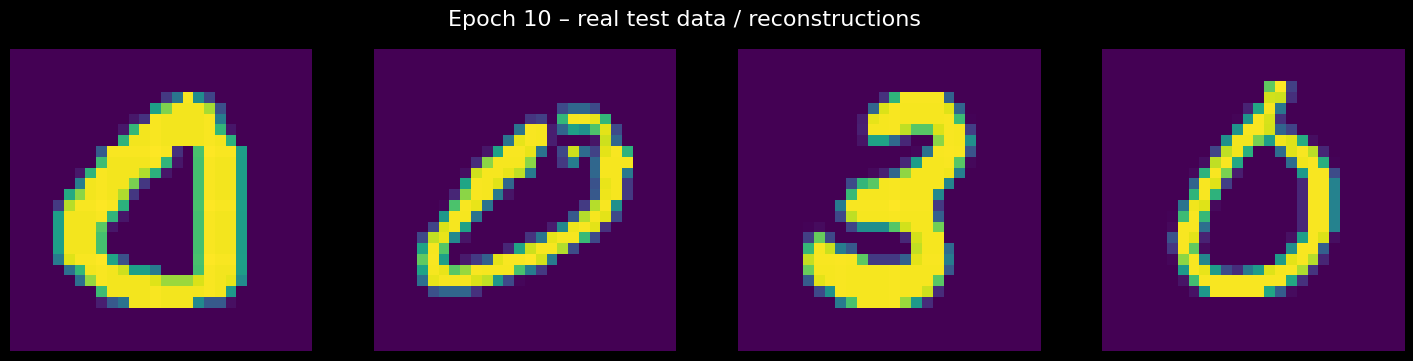

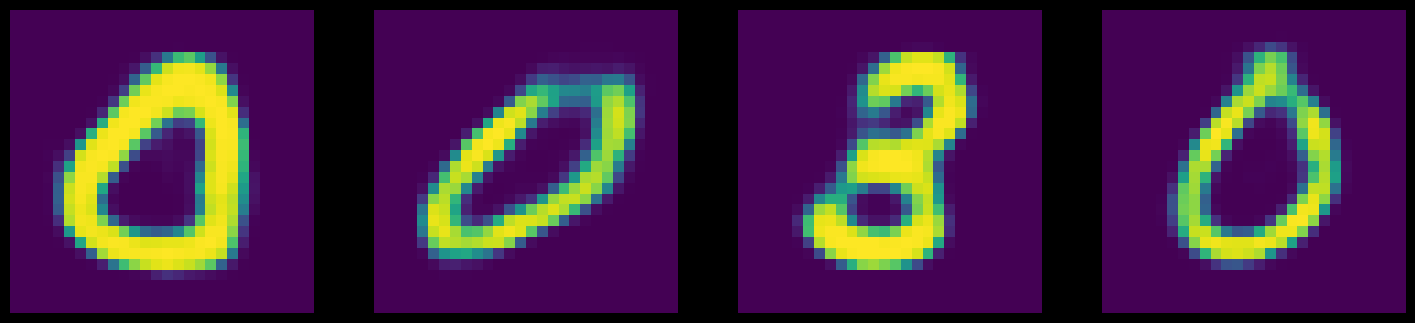

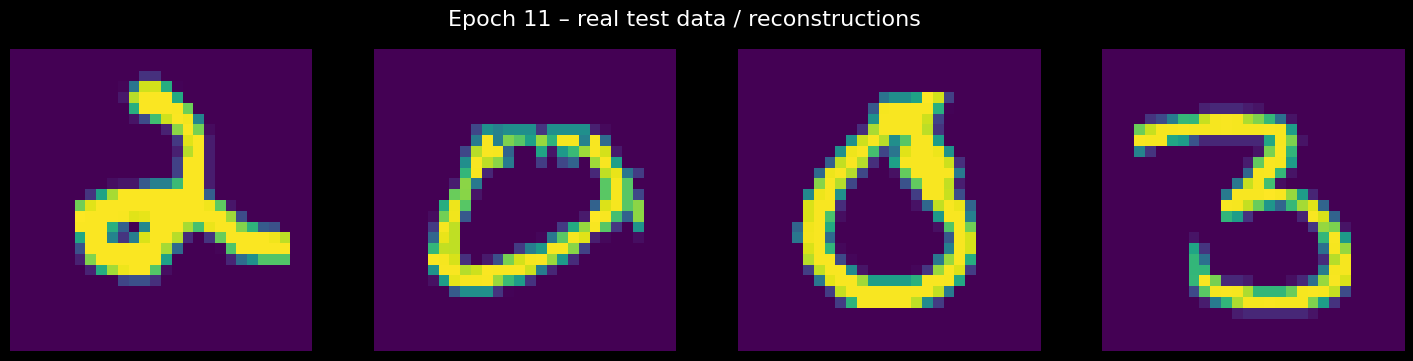

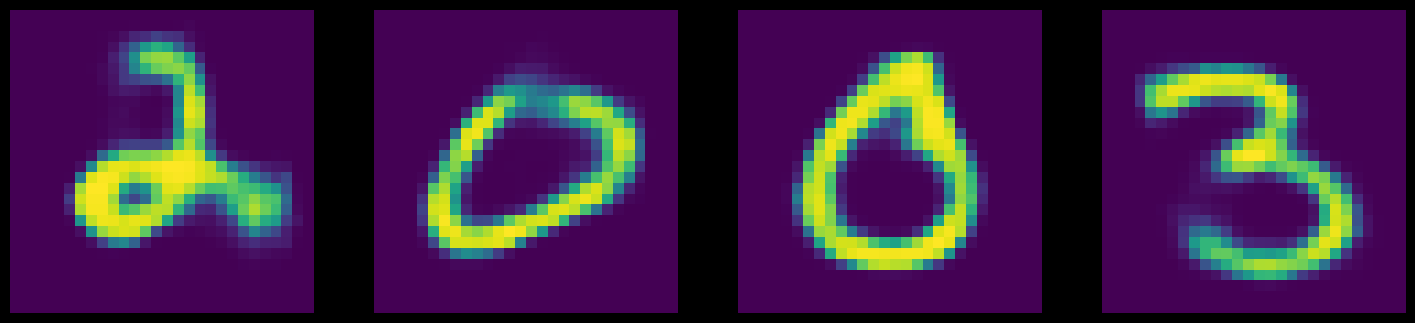

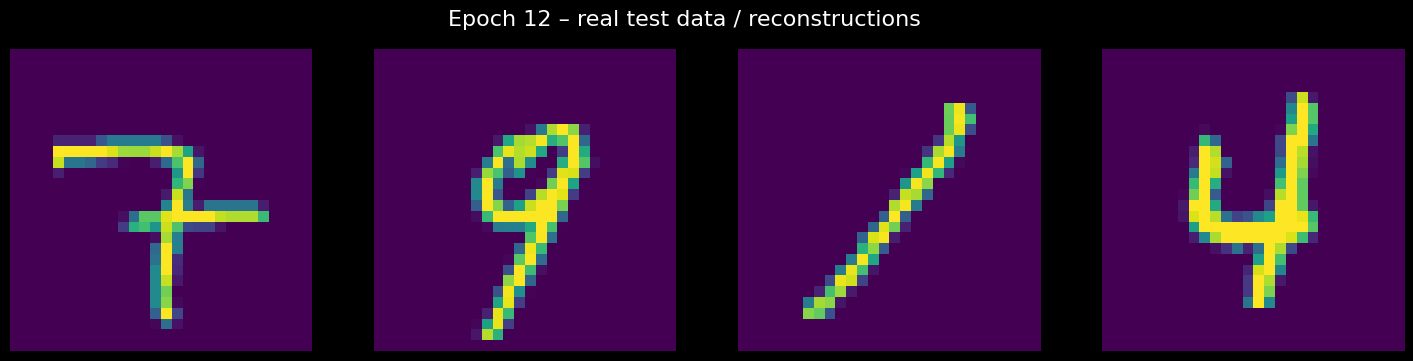

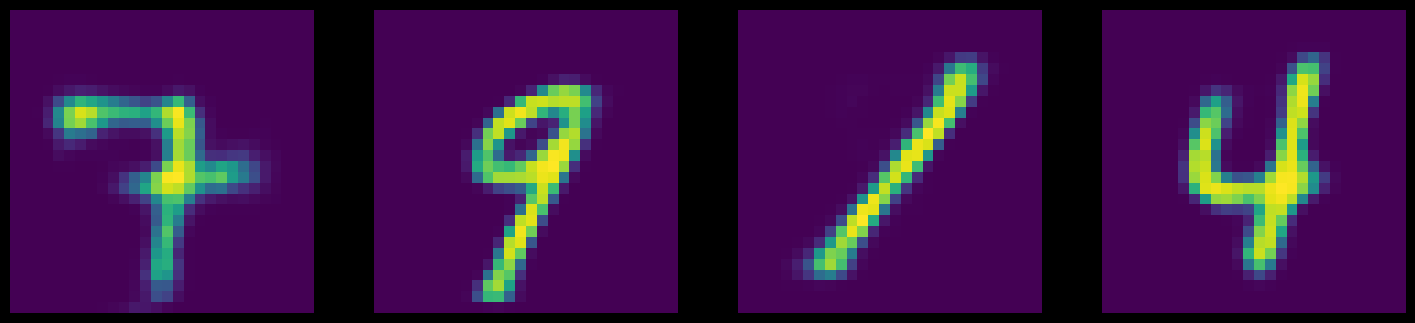

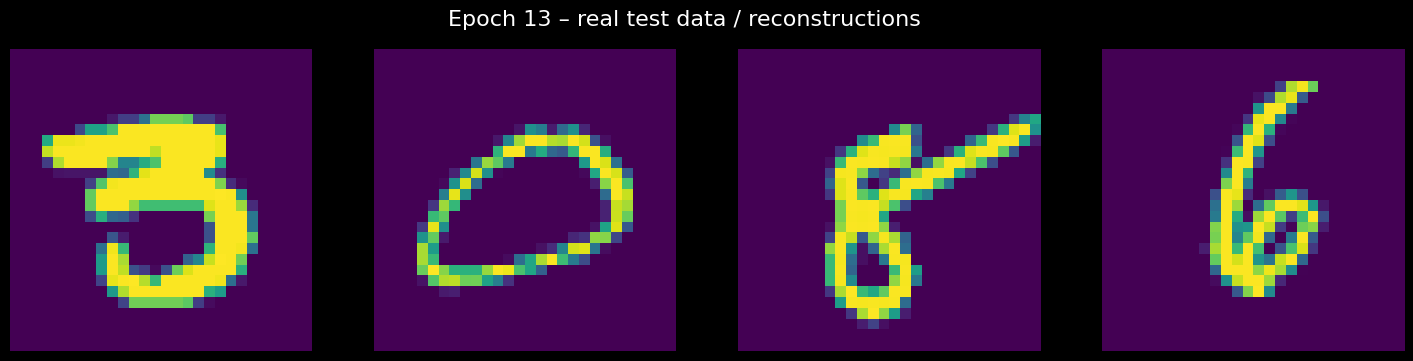

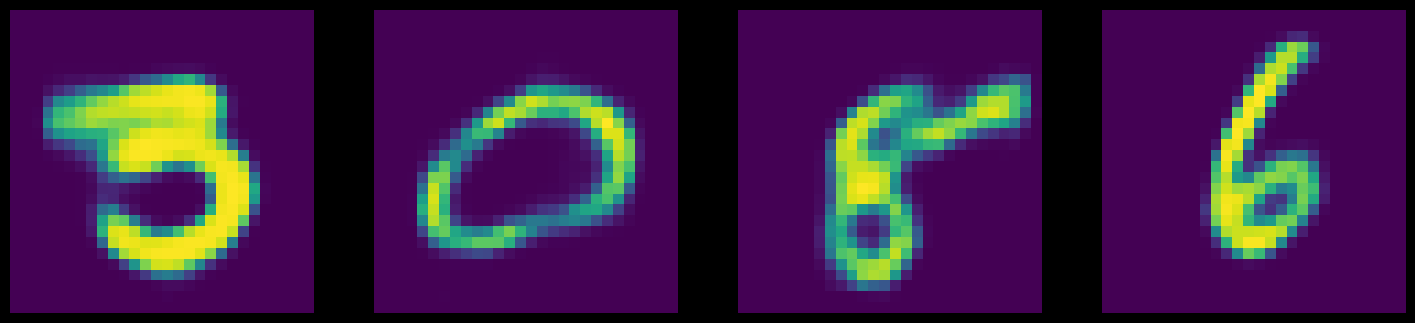

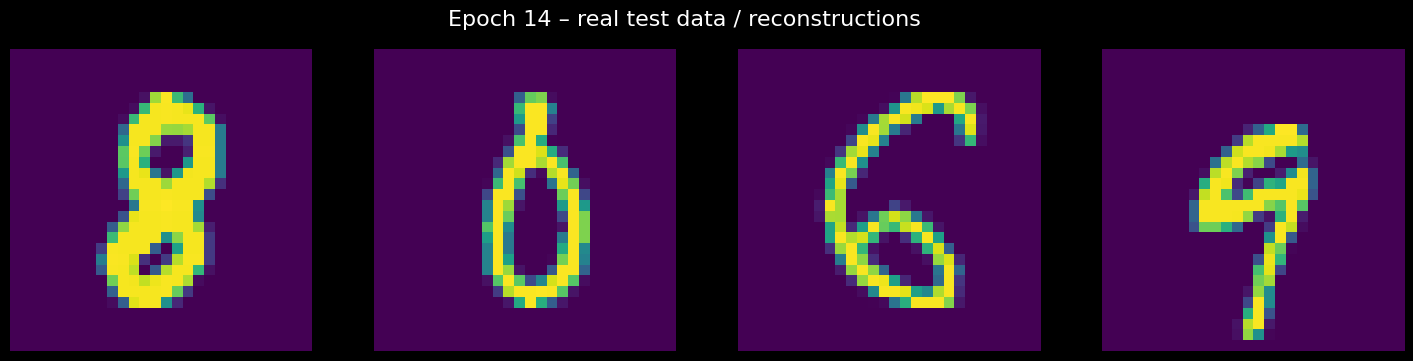

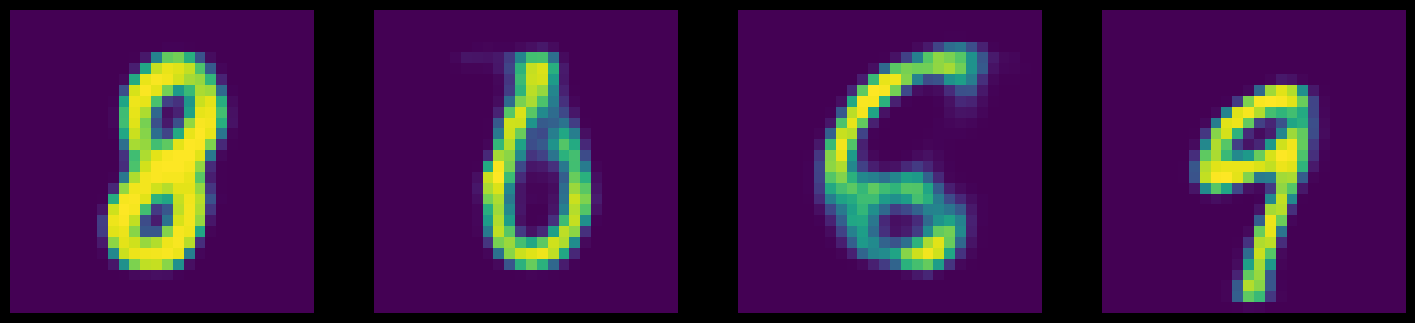

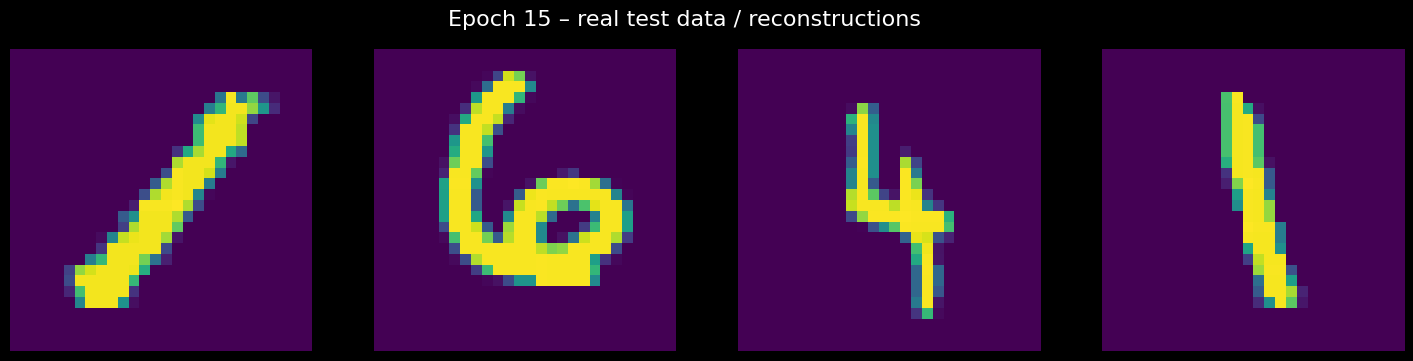

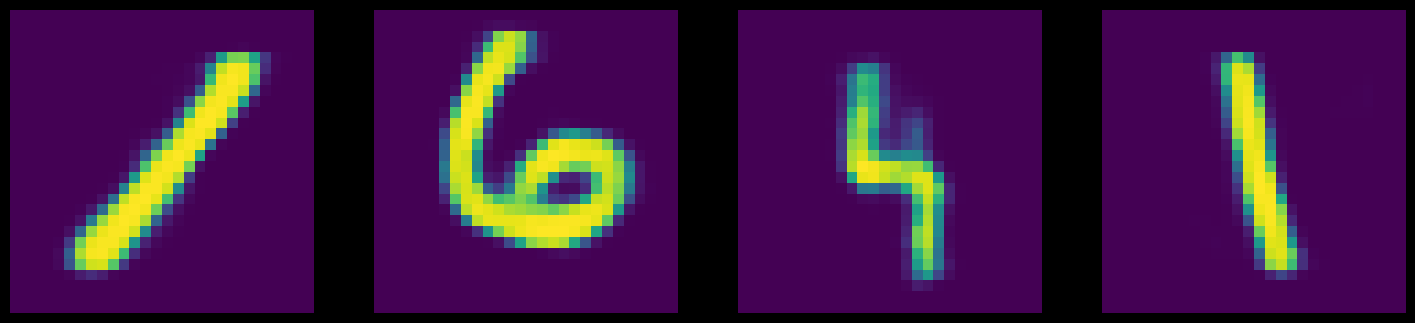

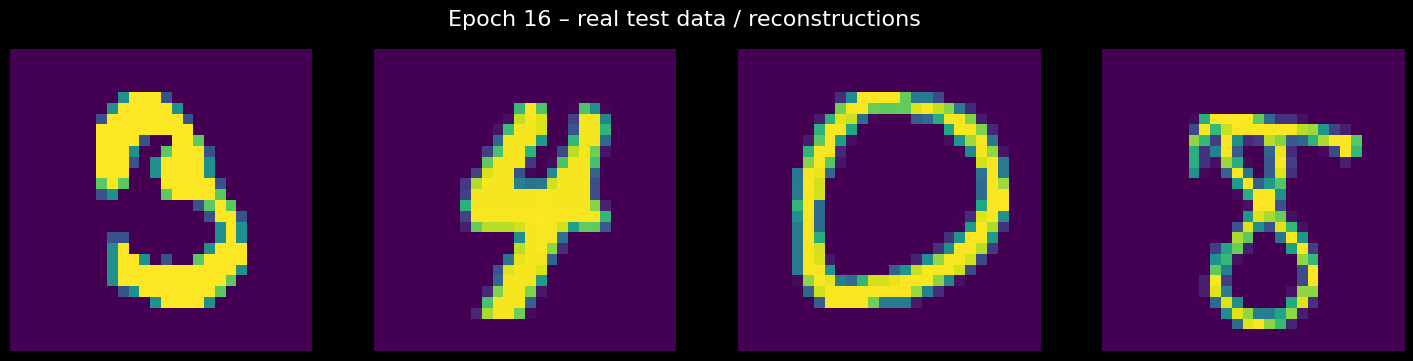

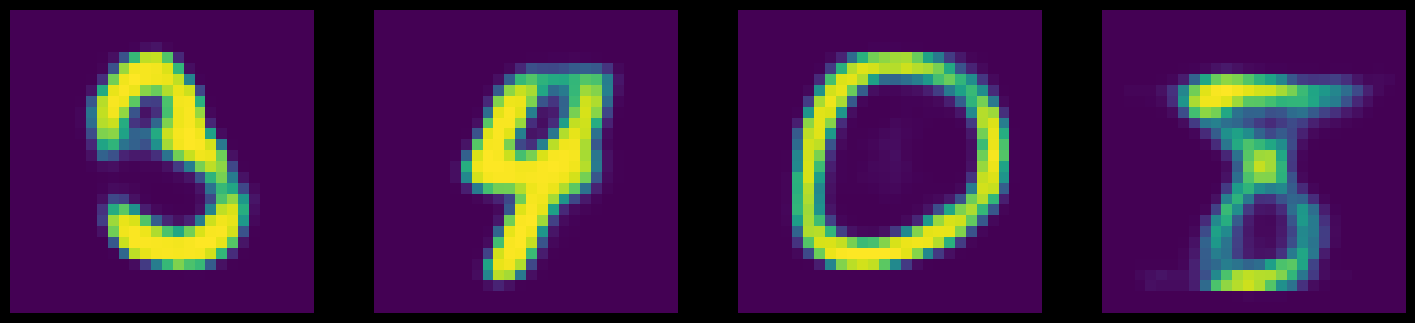

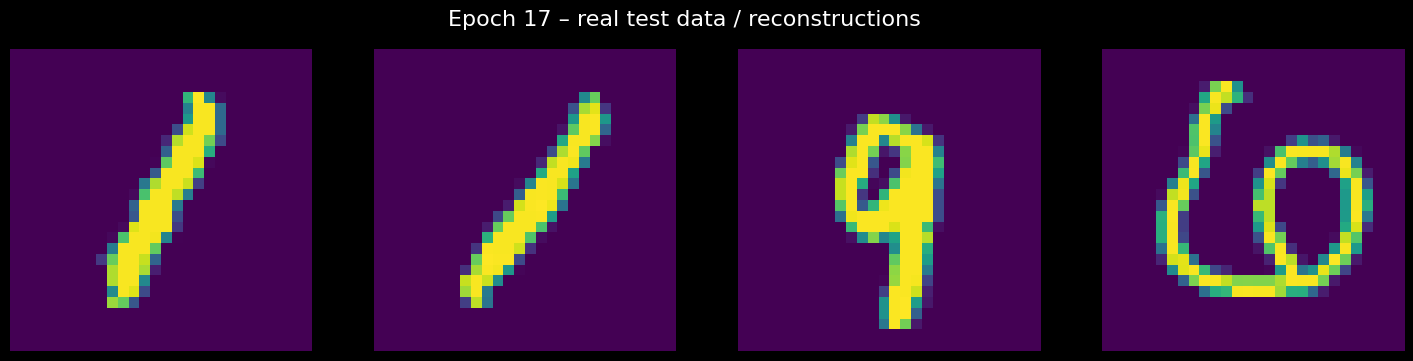

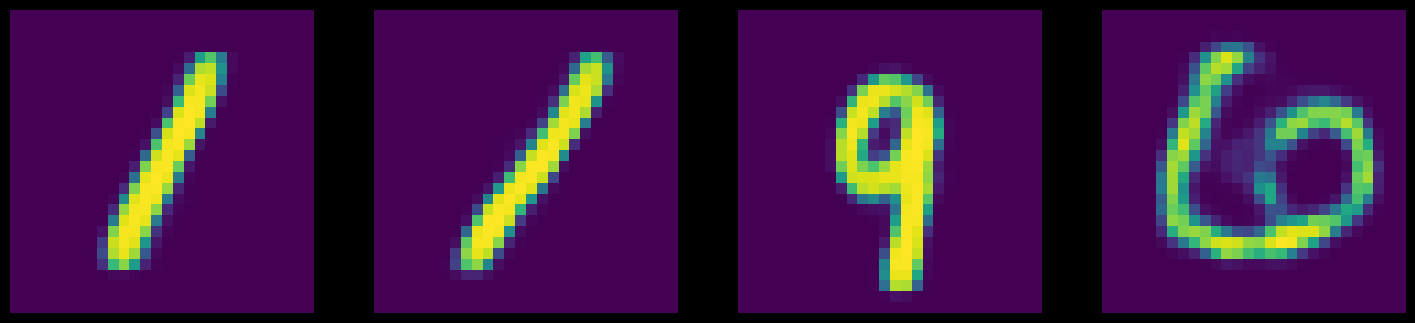

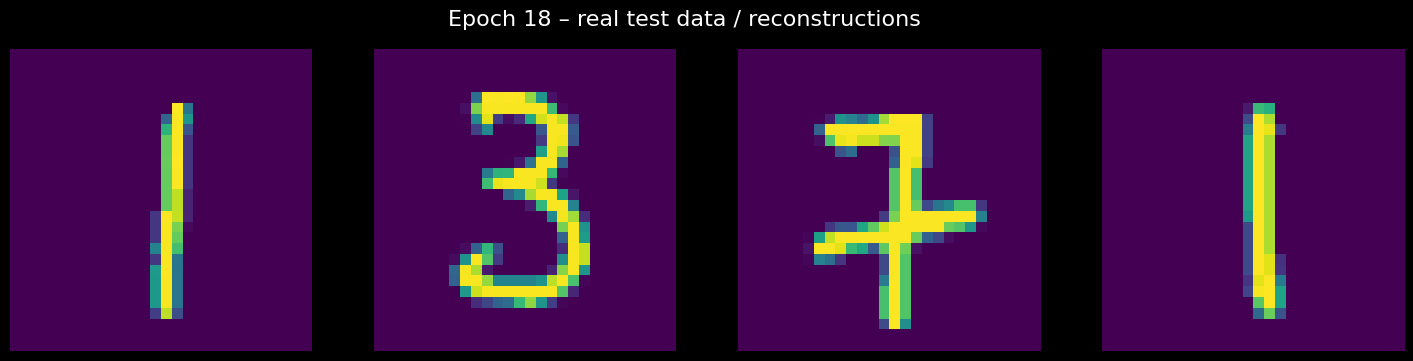

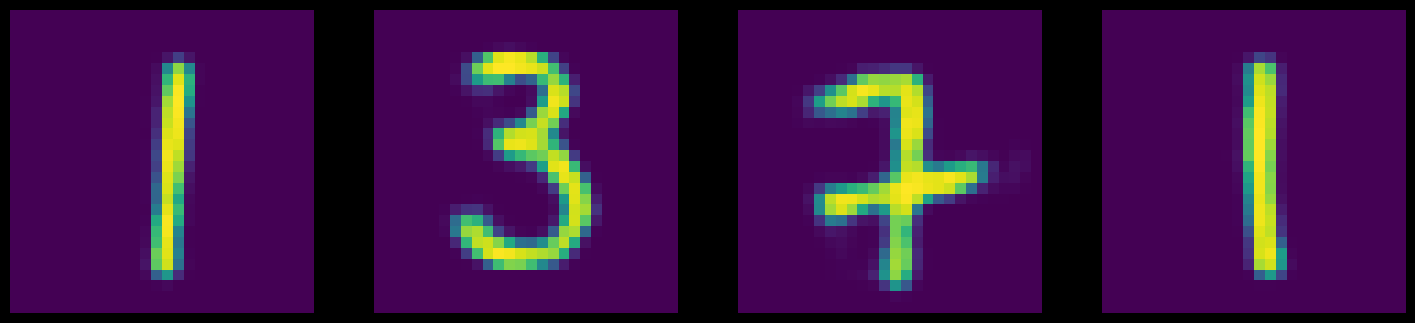

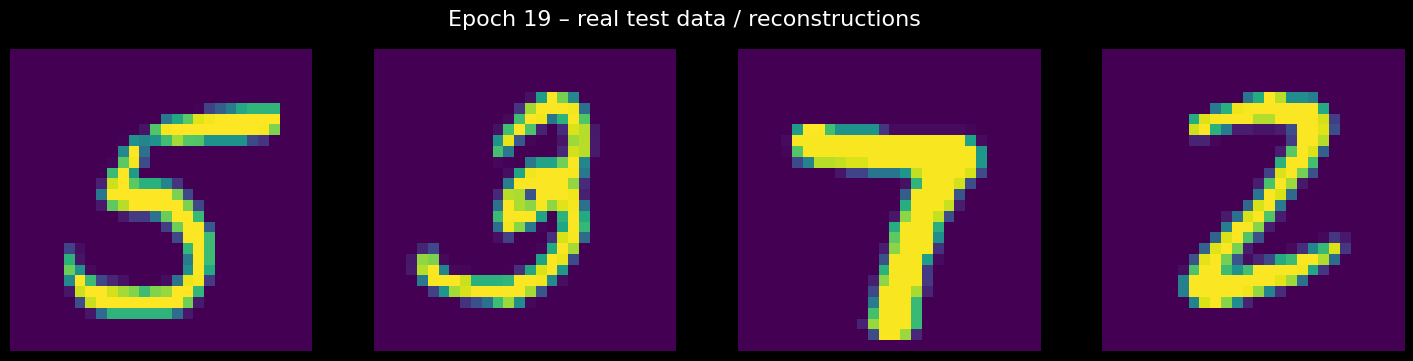

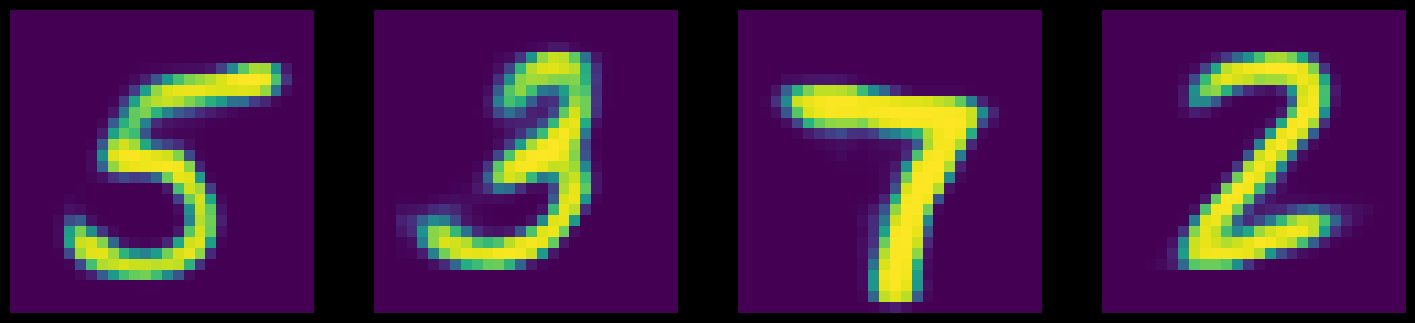

In [62]:
epochs = 20
codes = {'mu':[], 'logstd': [], 'y':[]}
for epoch in range(epochs):
    if epoch > 0:
        train_loss = 0
        for data, label in train_dataset:
            data = tf.reshape(data, (-1, 784))
            with tf.GradientTape() as tape:
                x_hat, mu, logstd = model(data, training=True)
                loss = loss_object(x_hat, data, mu, logstd)
                train_loss += loss.numpy()
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        print(f'====> Epoch: {epoch} Average loss: '
              f'{train_loss / len(train_dataset):.4f}')
    
    # Testing
    means, logstds, labels = [], [], []
    test_loss = 0
    for data, label in test_dataset:
        data = tf.reshape(data, (-1, 784))
        x_hat, mu, logstd = model(data, training=False)
        loss = loss_object(x_hat, data, mu, logstd)
        test_loss += loss.numpy()
        means.append(mu.numpy())
        logstds.append(logstd.numpy())
        labels.append(label.numpy())
    codes['mu'].append(np.concatenate(means,axis=0))
    codes['logstd'].append(np.concatenate(logstds, axis=0))
    codes['y'].append(np.concatenate(labels, axis=0))
    test_loss /= len(test_dataset)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(data.numpy(), x_hat.numpy(), 1, f'Epoch {epoch}')


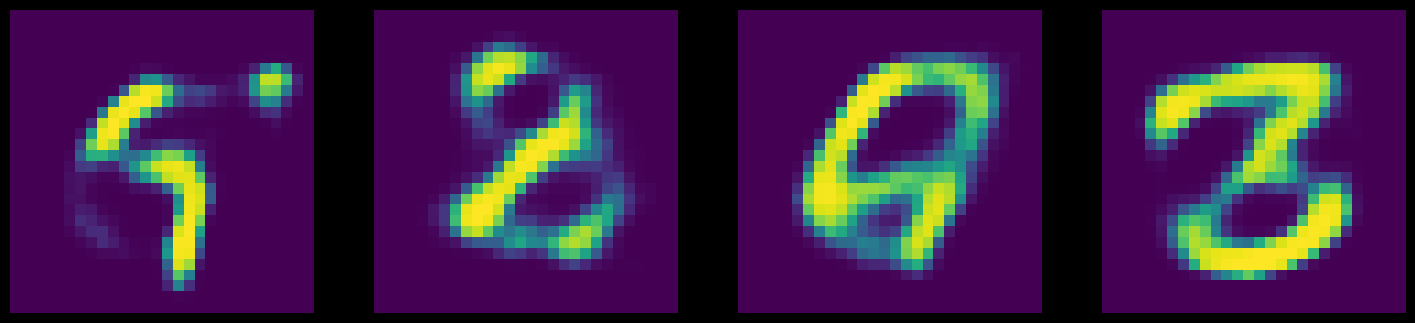

In [63]:
# Generate samples from normal random
z = tf.random.normal((4, d))
output = model.decoder(z)
display_images(None, output.numpy(), 1, f'Epoch 1')


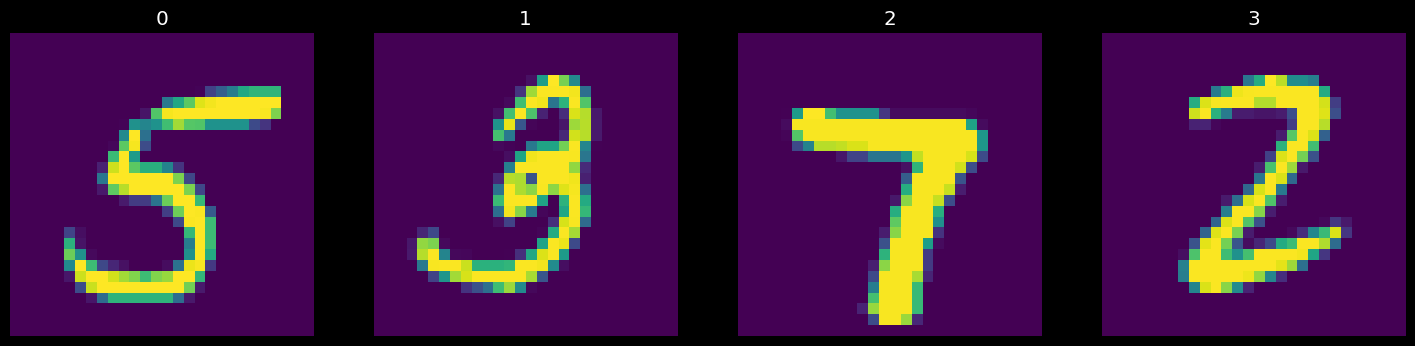

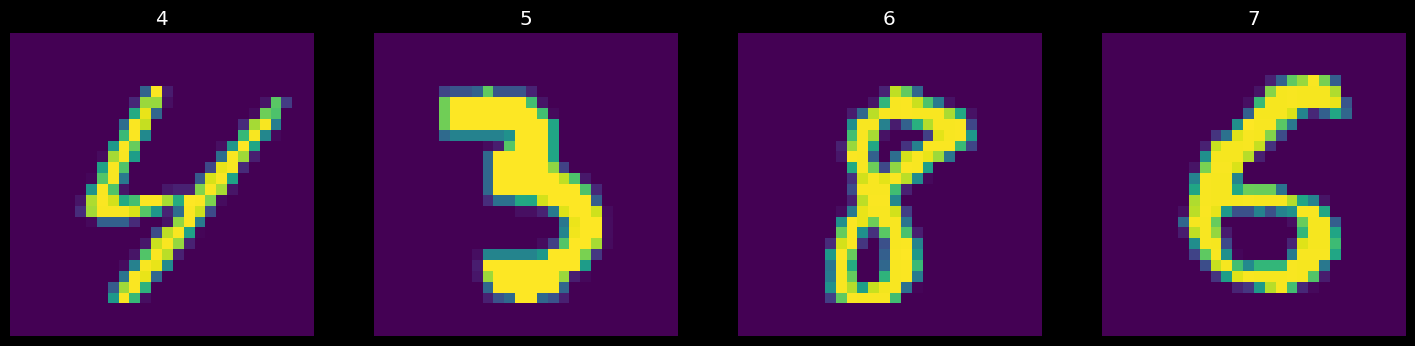

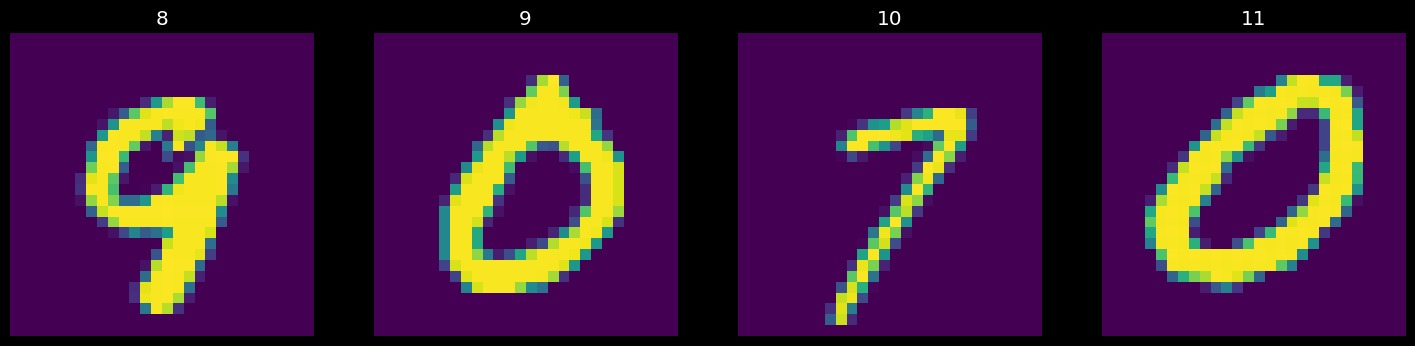

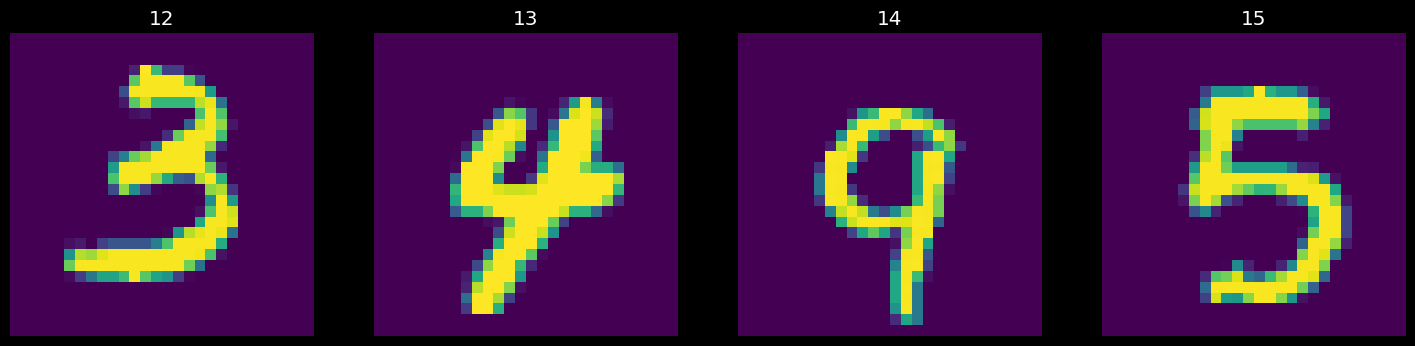

In [64]:
# Display last test batch
display_images(None, data.numpy(), 4, count=True)

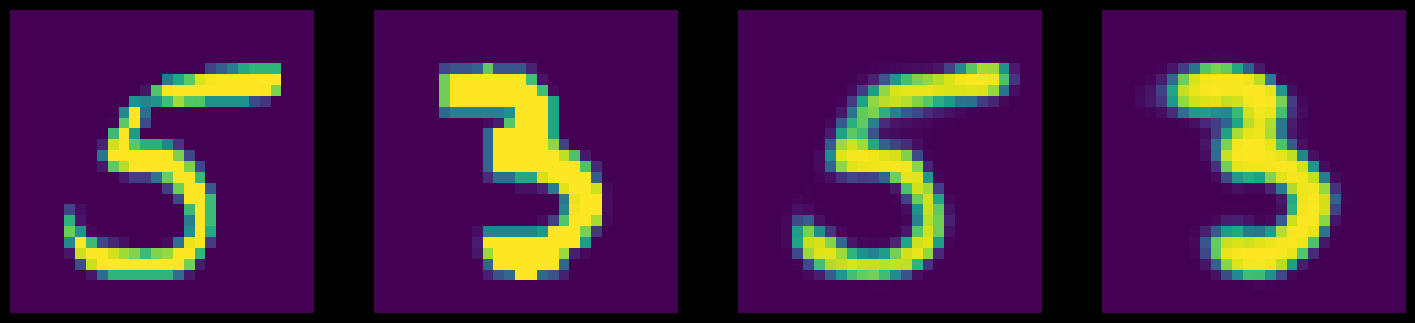

In [65]:
# Choose starting and ending point for the interpolation -> shows original and reconstructed
# First 2 pics are original, last 2 pics are reconstructed
A, B = 0, 5
sample = model.decoder(np.stack((mu[A], mu[B]), 0))
display_images(None, np.stack(((
    data.numpy()[A].reshape(-1),
    data.numpy()[B].reshape(-1),
    sample[0],
    sample[1]
)), 0))

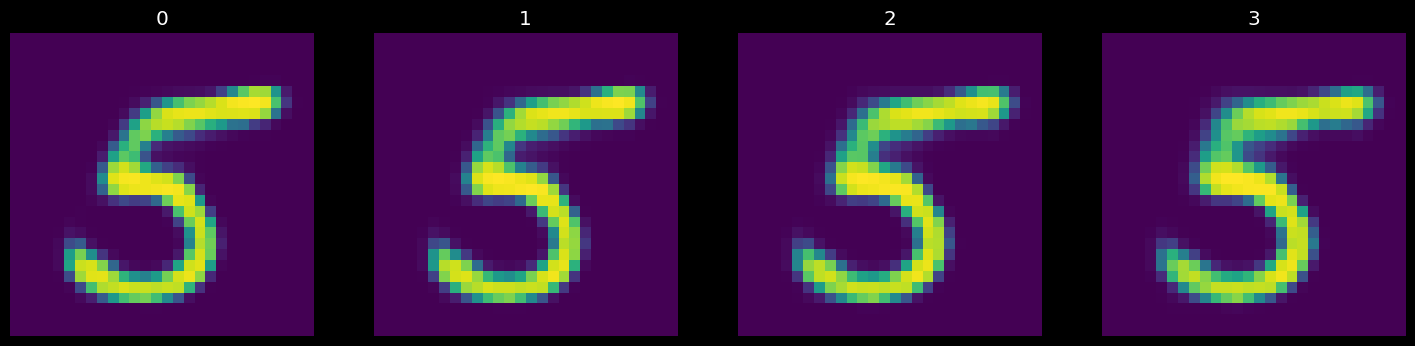

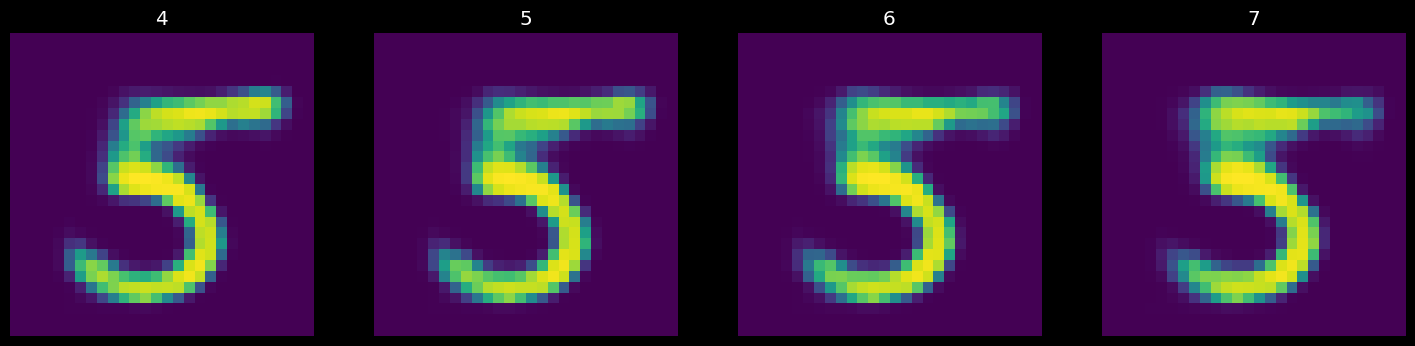

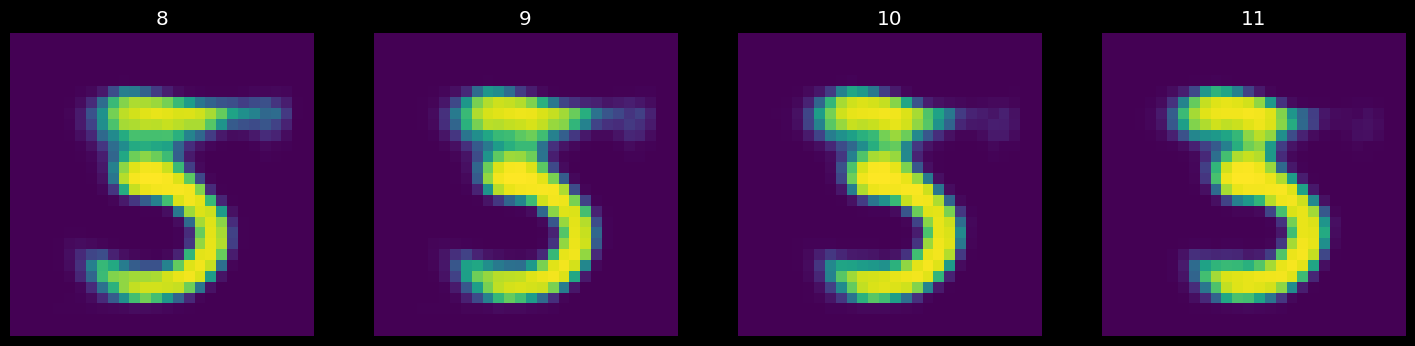

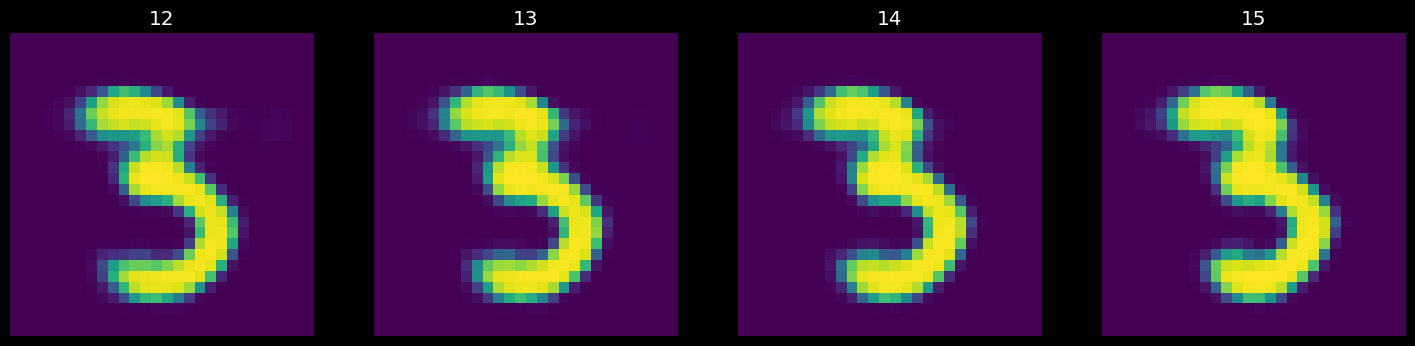

In [66]:
# Perform an interpolation between input A and B, in N steps

N = 16
code = np.zeros((N, 20))
sample = np.zeros((N, 28, 28))
for i in range(N):
    code[i] = i / (N - 1) * mu[B] + (1 - i / (N - 1) ) * mu[A]
    # sample[i] = i / (N - 1) * x[B].data + (1 - i / (N - 1) ) * x[A].data
sample = model.decoder(code)
display_images(None, sample.numpy(), N // 4, count=True)


In [67]:
import numpy as np
from sklearn.manifold import TSNE
from res.plot_lib import set_default

In [68]:
set_default(figsize=(15, 4))


In [69]:
X, Y, E = list(), list(), list()  # input, classes, embeddings
N = 1000  # samples per epoch
epochs = (0, 5, 10)
for epoch in epochs:
    X.append(codes['mu'][epoch][:N])
    E.append(TSNE(n_components=2).fit_transform(X[-1]))
    Y.append(codes['y'][epoch][:N])

In [70]:
print(f"Length of codes mu: {len(codes['mu'])}")
print(f"Length of each mu: {codes['mu'][0].shape}")

Length of codes mu: 20
Length of each mu: (10000, 20)


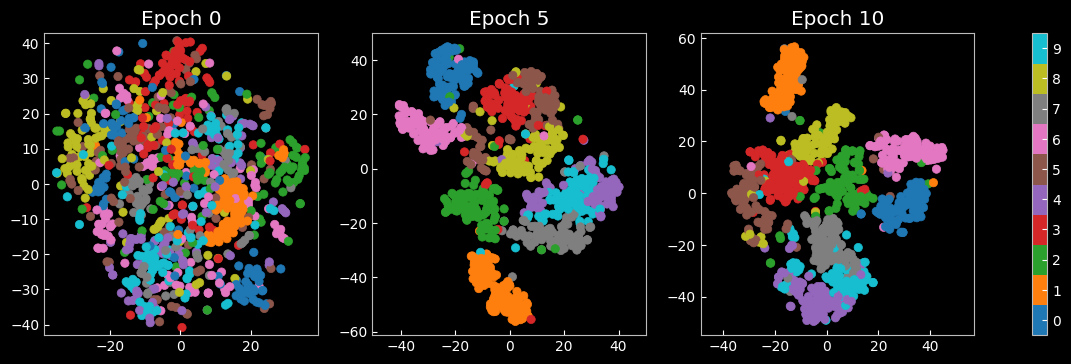

In [74]:
f, a = plt.subplots(ncols=3)
for i, e in enumerate(epochs):
    s = a[i].scatter(E[i][:,0], E[i][:,1], c=Y[i], cmap='tab10')
    a[i].grid(False)
    a[i].set_title(f'Epoch {e}')
    a[i].axis('equal')
f.colorbar(s, ax=a[:], ticks=np.arange(10), boundaries=np.arange(11) - .5)